In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
!pip install rdkit joblib catboost xgboost lightgbm fastparquet --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 58.8 MB/s eta 0:00:00


In [23]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
import seaborn as sns
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from tqdm import tqdm
import fastparquet

In [3]:
train_df = pd.read_parquet('/content/drive/MyDrive/DS5500/train_df_long_dt.parquet')

In [4]:

eval_df = pd.read_csv('/content/drive/MyDrive/DS5500/val_df_subset.csv')

In [6]:
train_df.head()

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_names,binds,ecfp
0,O=C(N[C@@H](Cc1ccc(F)cc1)C(=O)O)OCC1c2ccccc2-c...,COc1cccc(-c2cc(N)on2)c1,Cl.Cl.NCCC(=O)Nc1ccncc1,COc1cccc(-c2cc(Nc3nc(NCCC(=O)Nc4ccncc4)nc(N[C@...,BRD4,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,COc1cc(NC(=O)OCC2c3ccccc3-c3ccccc32)c(C(=O)O)c...,NCc1cccc(C(F)(F)F)n1,Cl.Cl.NCc1nccc2[nH]ccc12,COc1cc(Nc2nc(NCc3cccc(C(F)(F)F)n3)nc(NCc3nccc4...,BRD4,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,O=C(Nc1ccc(C(=O)O)cc1O)OCC1c2ccccc2-c2ccccc21,C=C(C)C(=O)NCCN.Cl,CSc1nnc(CN)s1,C=C(C)C(=O)NCCNc1nc(NCc2nnc(SC)s2)nc(Nc2ccc(C(...,BRD4,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,O=C(O)[C@H]1Cc2ccccc2CN1C(=O)OCC1c2ccccc2-c2cc...,Nc1cccnc1[N+](=O)[O-],CC1CC(CN)C(C)O1,CC1CC(CNc2nc(Nc3cccnc3[N+](=O)[O-])nc(N3Cc4ccc...,BRD4,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O=C(N[C@@H](Cc1c(F)c(F)c(F)c(F)c1F)C(=O)O)OCC1...,CN1C(=O)Cc2cc(CN)ccc21.Cl,Cl.Cl.NCc1ccc2scnc2c1,CN1C(=O)Cc2cc(CNc3nc(NCc4ccc5scnc5c4)nc(N[C@@H...,BRD4,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
eval_df.head()

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,BRD4,HSA,sEH
0,O=C(O)C[C@@H](Cc1ccc([N+](=O)[O-])cc1)NC(=O)OC...,NCCCCN1CCCC1,CC1CC(CN)C(C)O1,CC1CC(CNc2nc(NCCCCN3CCCC3)nc(N[C@@H](CC(=O)N[D...,0,0,0
1,Cc1c(Br)ccc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21,Cl.NCc1nc2ccccc2o1,Cl.NCc1nc(-c2ccco2)n[nH]1,Cc1c(Br)ccc(C(=O)N[Dy])c1Nc1nc(NCc2nc(-c3ccco3...,0,0,0
2,O=C(Nc1c(C(=O)O)cccc1C(=O)O)OCC1c2ccccc2-c2ccc...,Cc1cc(N)n(-c2ccccc2)n1,COc1ccc([N+](=O)[O-])c(N)n1,COc1ccc([N+](=O)[O-])c(Nc2nc(Nc3c(C(=O)O)cccc3...,0,0,0
3,O=C(Nc1ccc([N+](=O)[O-])c(C(=O)O)c1)OCC1c2cccc...,NCCN1CCC2(C1)OCCO2,Cc1n[nH]c(N)c1C,Cc1n[nH]c(Nc2nc(NCCN3CCC4(C3)OCCO4)nc(Nc3ccc([...,0,0,0
4,Cc1ccc(C(=O)O)c(NC(=O)OCC2c3ccccc3-c3ccccc32)c1C,COC(CN)CC(N)=O.Cl,Cl.Nc1ccc(O)cc1Cl,COC(CNc1nc(Nc2ccc(O)cc2Cl)nc(Nc2c(C(=O)N[Dy])c...,0,0,0


In [15]:
# Define the function for parallel processing
def smiles_to_mol(smiles):
    return Chem.MolFromSmiles(smiles)

# Use joblib's Parallel to convert SMILES in parallel
eval_df['molecule'] = Parallel(n_jobs=-1)(delayed(smiles_to_mol)(smiles) for smiles in tqdm(eval_df['molecule_smiles']))

100%|██████████| 1132335/1132335 [02:04<00:00, 9100.66it/s] 


In [16]:
from tqdm import tqdm

# Define the fingerprint generation function
def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return None
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius=radius, nBits=bits))

In [17]:
# Use Parallel with joblib to process fingerprints in parallel
eval_df['ecfp'] = Parallel(n_jobs=-1)(delayed(generate_ecfp)(mol) for mol in tqdm(eval_df['molecule']))

100%|██████████| 1132335/1132335 [13:33<00:00, 1391.99it/s]


In [18]:
eval_df_long = pd.melt(
    eval_df,
    id_vars=["buildingblock1_smiles", "buildingblock2_smiles", "buildingblock3_smiles", "molecule_smiles", "ecfp"],
    value_vars=["BRD4", "HSA", "sEH"],
    var_name="protein_names",
    value_name="binds"
)


In [19]:
eval_df_long.head()

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,ecfp,protein_names,binds
0,O=C(O)C[C@@H](Cc1ccc([N+](=O)[O-])cc1)NC(=O)OC...,NCCCCN1CCCC1,CC1CC(CN)C(C)O1,CC1CC(CNc2nc(NCCCCN3CCCC3)nc(N[C@@H](CC(=O)N[D...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",BRD4,0
1,Cc1c(Br)ccc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21,Cl.NCc1nc2ccccc2o1,Cl.NCc1nc(-c2ccco2)n[nH]1,Cc1c(Br)ccc(C(=O)N[Dy])c1Nc1nc(NCc2nc(-c3ccco3...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",BRD4,0
2,O=C(Nc1c(C(=O)O)cccc1C(=O)O)OCC1c2ccccc2-c2ccc...,Cc1cc(N)n(-c2ccccc2)n1,COc1ccc([N+](=O)[O-])c(N)n1,COc1ccc([N+](=O)[O-])c(Nc2nc(Nc3c(C(=O)O)cccc3...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",BRD4,0
3,O=C(Nc1ccc([N+](=O)[O-])c(C(=O)O)c1)OCC1c2cccc...,NCCN1CCC2(C1)OCCO2,Cc1n[nH]c(N)c1C,Cc1n[nH]c(Nc2nc(NCCN3CCC4(C3)OCCO4)nc(Nc3ccc([...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",BRD4,0
4,Cc1ccc(C(=O)O)c(NC(=O)OCC2c3ccccc3-c3ccccc32)c1C,COC(CN)CC(N)=O.Cl,Cl.Nc1ccc(O)cc1Cl,COC(CNc1nc(Nc2ccc(O)cc2Cl)nc(Nc2c(C(=O)N[Dy])c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",BRD4,0


In [61]:
eval_df_long.to_parquet('/content/drive/MyDrive/DS5500/eval_df_long_dt.parquet', engine='fastparquet')

In [24]:
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, confusion_matrix, classification_report
)
import lightgbm  # Import the lightgbm library
from catboost import CatBoostClassifier
import numpy as np
#from tqdm.notebook import tqdm  # For progress bar

# OneHotEncode the 'protein_name' column
onehot_encoder = OneHotEncoder(sparse_output=False)  # Use sparse=False for dense matrix
onehot_encoder

OneHotEncoder(sparse_output=False)

In [25]:
protein_onehot_train = onehot_encoder.fit_transform(train_df['protein_names'].values.reshape(-1, 1))

In [26]:
protein_onehot_eval = onehot_encoder.transform(eval_df_long['protein_names'].values.reshape(-1, 1))

###Save encoder info to be used at a later date

In [62]:
# Save the encoded data
train_path = "/content/drive/MyDrive/DS5500/encoder/protein_onehot_train.npy"
eval_path = "/content/drive/MyDrive/DS5500/encoder/protein_onehot_eval.npy"
encoder_path = "/content/drive/MyDrive/DS5500/encoder/onehot_encoder.joblib"

np.save(train_path, protein_onehot_train)
np.save(eval_path, protein_onehot_eval)
joblib.dump(onehot_encoder, encoder_path)



['/content/drive/MyDrive/DS5500/encoder/onehot_encoder.joblib']

In [63]:
train_path, eval_path, encoder_path

('/content/drive/MyDrive/DS5500/encoder/protein_onehot_train.npy',
 '/content/drive/MyDrive/DS5500/encoder/protein_onehot_eval.npy',
 '/content/drive/MyDrive/DS5500/encoder/onehot_encoder.joblib')

###Load encoder info to be used at a later date

In [ ]:
# import numpy as np
# import joblib

# # Paths to the saved files
# train_path = "/content/drive/MyDrive/DS5500/encoder/protein_onehot_train.npy"
# eval_path = "/content/drive/MyDrive/DS5500/encoder/protein_onehot_eval.npy"
# encoder_path = "/content/drive/MyDrive/DS5500/encoder/onehot_encoder.joblib"

# # Load the one-hot encoded data
# protein_onehot_train = np.load(train_path)
# protein_onehot_eval = np.load(eval_path)

# # Load the OneHotEncoder
# onehot_encoder = joblib.load(encoder_path)

# # Verify loaded data
# print("Protein OneHot Train:", protein_onehot_train)
# print("Protein OneHot Eval:", protein_onehot_eval)

In [28]:
# Convert lists to NumPy arrays
ecfp_array = np.array(eval_df_long['ecfp'].tolist(), dtype=np.float32)
protein_array = np.array(protein_onehot_eval.tolist(), dtype=np.float32)
binds_array = np.array(eval_df_long['binds'].tolist(), dtype=np.int8)

# Combine arrays
X_eval = np.hstack((ecfp_array, protein_array))
y_eval = binds_array

print("X:", X_eval)
print("y:", y_eval)

X: [[0. 1. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]]
y: [0 0 0 ... 0 0 0]


##XGBoost Baseline Model Evaluation

Loaded XGBoost model from /content/drive/MyDrive/DS5500/saved_models/XGBoost.pkl


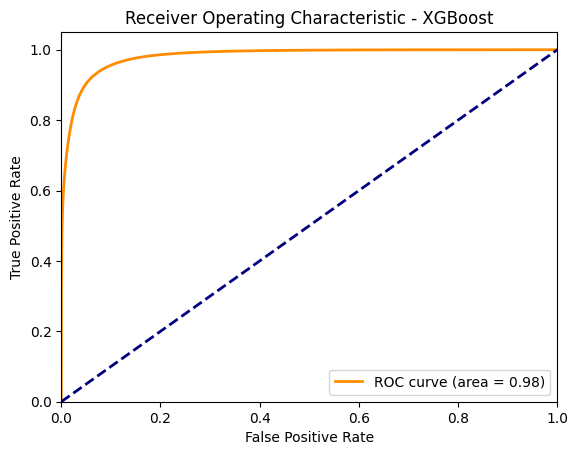

Accuracy: 0.96


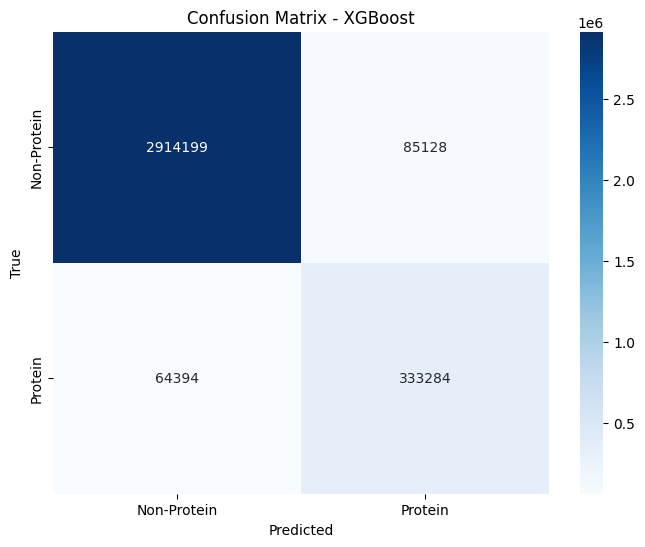

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97   2999327
           1       0.80      0.84      0.82    397678

    accuracy                           0.96   3397005
   macro avg       0.89      0.90      0.90   3397005
weighted avg       0.96      0.96      0.96   3397005



In [32]:
# Define file path
model_path = "/content/drive/MyDrive/DS5500/saved_models/XGBoost.pkl"

# Load the saved XGBoost model
try:
    model = joblib.load(model_path)
    print(f"Loaded XGBoost model from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    raise

# Predictions
y_pred_eval = model.predict(X_eval)

# ROC Curve
fpr, tpr, _ = roc_curve(y_eval, model.predict_proba(X_eval)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

# Accuracy
acc = accuracy_score(y_eval, y_pred_eval)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_eval, y_pred_eval)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_eval, y_pred_eval))

In [34]:
# Metrics
pred_proba_eval = model.predict_proba(X_eval)[:, 1] if hasattr(model, "predict_proba") else None
accuracy = accuracy_score(y_eval, y_pred_eval)
weighted_map = (
  average_precision_score(y_eval, pred_proba_eval, average='weighted') if pred_proba_eval is not None else None
)

# Display results
print(f"Model: XGBoost")
print(f"Accuracy: {accuracy:.2f}")
if weighted_map is not None:
  print(f"Weighted mAP: {weighted_map:.2f}")


Model: XGBoost
Accuracy: 0.96
Weighted mAP: 0.90


##Ensemble Baseline Model Evaluation

In [54]:
# Load trained models
models = {
    "XGBoost": joblib.load("/content/drive/MyDrive/DS5500/saved_models/XGBoost.pkl"),
    "LGBM": joblib.load("/content/drive/MyDrive/DS5500/LGBM.pkl"),
    "CatBoost": joblib.load("//content/drive/MyDrive/DS5500/CatBoost.pkl")
}

# Generate meta-features for validation data
X_meta_eval = np.column_stack([
    models["XGBoost"].predict_proba(X_eval)[:, 1],
    models["LGBM"].predict_proba(X_eval)[:, 1],
    models["CatBoost"].predict_proba(X_eval)[:, 1]
])

# The target remains the same
y_meta_eval = y_eval


In [59]:
# Load the saved stacking model
meta_model = joblib.load('/content/drive/MyDrive/DS5500/saved_models/meta_model.pkl')
print("Stacking model loaded successfully.")

# Predictions
pred_model_eval = meta_model.predict(X_meta_eval)
pred_proba_eval = meta_model.predict_proba(X_meta_eval)[:, 1] if hasattr(meta_model, "predict_proba") else None

# Metrics
accuracy = accuracy_score(y_meta_eval, pred_model_eval)
weighted_map = (
average_precision_score(y_meta_eval, pred_proba_eval, average='weighted') if pred_proba_eval is not None else None
)

# Classification report
report = classification_report(y_meta_eval, pred_model_eval)

# Display results
print(f"Model: Ensemble model using stacking")
print(f"Accuracy: {accuracy:.2f}")
if weighted_map is not None:
  print(f"Weighted mAP: {weighted_map:.2f}")
  print(report)

Stacking model loaded successfully.
Model: Ensemble model using stacking
Accuracy: 0.96
Weighted mAP: 0.88
              precision    recall  f1-score   support

           0       0.96      0.99      0.98   2999327
           1       0.88      0.72      0.80    397678

    accuracy                           0.96   3397005
   macro avg       0.92      0.86      0.89   3397005
weighted avg       0.95      0.96      0.95   3397005



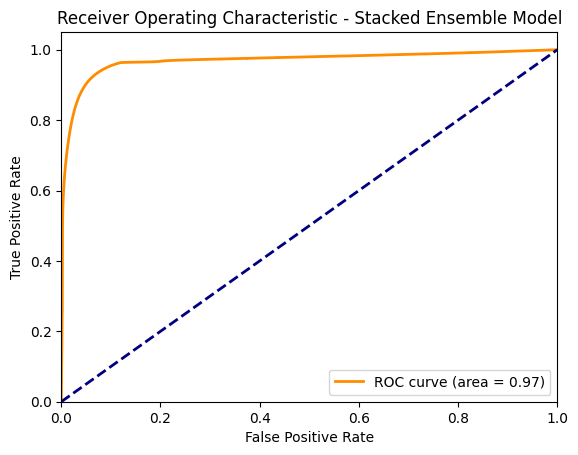

Stacking Model Accuracy: 0.96


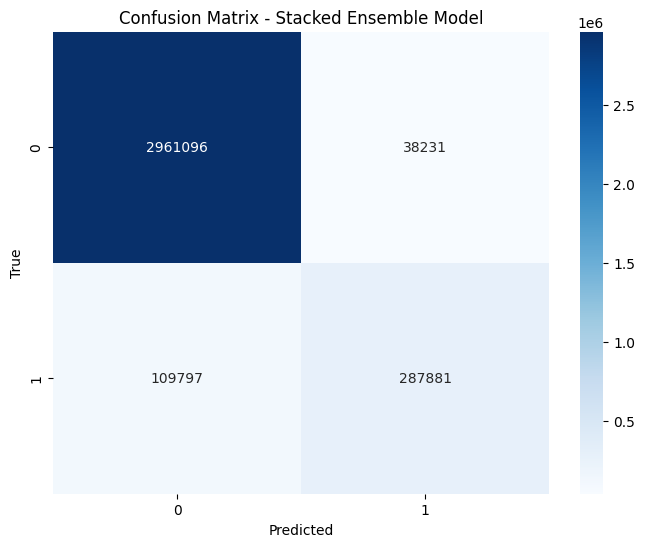

In [60]:
# Use the loaded model for predictions
y_pred_eval = meta_model.predict(X_meta_eval)

# Check if the model supports predict_proba for ROC Curve
if hasattr(meta_model, "predict_proba"):
    # Generate probabilities for the positive class
    proba_positive_eval = meta_model.predict_proba(X_meta_eval)[:, 1]

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_meta_eval, proba_positive_eval)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Stacked Ensemble Model')
    plt.legend(loc="lower right")
    plt.grid(False)
    plt.show()

else:
    print("The model does not support `predict_proba`. ROC curve cannot be generated.")

# Accuracy
accuracy = accuracy_score(y_meta_eval, y_pred_eval)
print(f"Stacking Model Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_meta_eval, y_pred_eval)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Stacked Ensemble Model')
plt.xlabel('Predicted')
plt.ylabel('True')
# Update xticks and yticks dynamically based on unique classes in y_val
class_labels = sorted(set(y_meta_eval))
plt.xticks(ticks=[i + 0.5 for i in range(len(class_labels))], labels=class_labels)
plt.yticks(ticks=[i + 0.5 for i in range(len(class_labels))], labels=class_labels)
plt.show()

##LGBM Model Baseline Model Evaluation

Loaded LGBM model from /content/drive/MyDrive/DS5500/LGBM.pkl


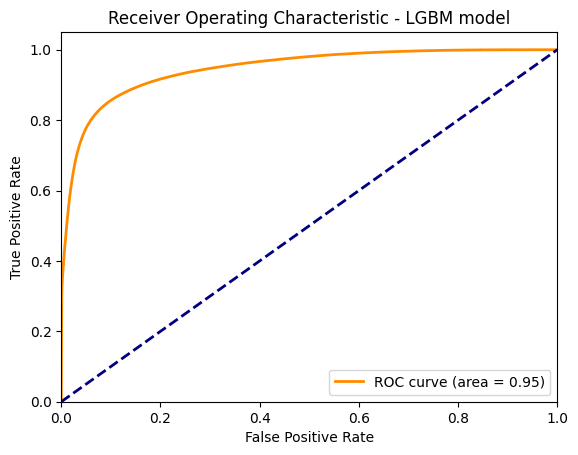

Accuracy: 0.91


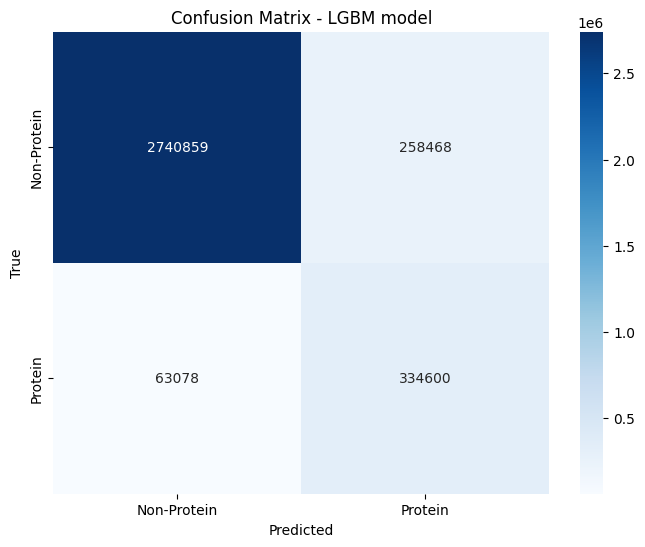

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94   2999327
           1       0.56      0.84      0.68    397678

    accuracy                           0.91   3397005
   macro avg       0.77      0.88      0.81   3397005
weighted avg       0.93      0.91      0.91   3397005



In [41]:
# Define file path
model_path = "/content/drive/MyDrive/DS5500/LGBM.pkl"

# Load the saved LGBM model
try:
    model = joblib.load(model_path)
    print(f"Loaded LGBM model from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    raise


# Predictions
y_pred_eval = model.predict(X_eval)

# ROC Curve
fpr, tpr, _ = roc_curve(y_eval, model.predict_proba(X_eval)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - LGBM model')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

# Accuracy
acc = accuracy_score(y_eval, y_pred_eval)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_eval, y_pred_eval)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LGBM model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_eval, y_pred_eval))

In [42]:
# Metrics
pred_proba_eval = model.predict_proba(X_eval)[:, 1] if hasattr(model, "predict_proba") else None
accuracy = accuracy_score(y_eval, y_pred_eval)
weighted_map = (
  average_precision_score(y_eval, pred_proba_eval, average='weighted') if pred_proba_eval is not None else None
)

# Display results
print(f"Model: LGBM Model")
print(f"Accuracy: {accuracy:.2f}")
if weighted_map is not None:
  print(f"Weighted mAP: {weighted_map:.2f}")


Model: LGBM Model
Accuracy: 0.91
Weighted mAP: 0.79


##Catboost Baseline Model Evaluation

Loaded CatBoost model from /content/drive/MyDrive/DS5500/CatBoost.pkl


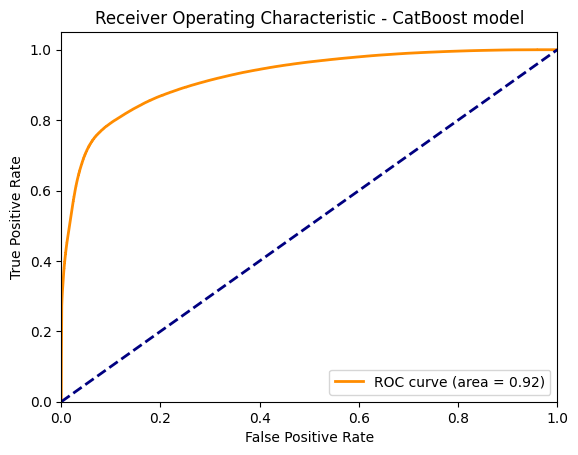

Accuracy: 0.89


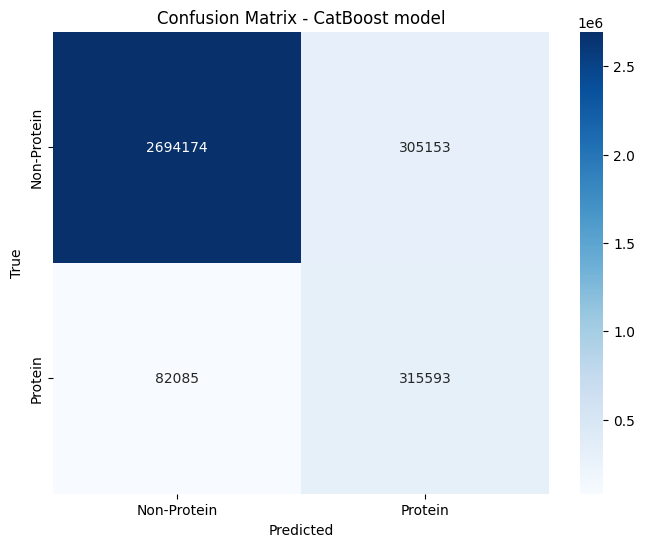

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93   2999327
           1       0.51      0.79      0.62    397678

    accuracy                           0.89   3397005
   macro avg       0.74      0.85      0.78   3397005
weighted avg       0.92      0.89      0.90   3397005



In [44]:
# Define file path
model_path = "/content/drive/MyDrive/DS5500/CatBoost.pkl"

# Load the saved LGBM model
try:
    model = joblib.load(model_path)
    print(f"Loaded CatBoost model from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    raise


# Predictions
y_pred_eval = model.predict(X_eval)

# ROC Curve
fpr, tpr, _ = roc_curve(y_eval, model.predict_proba(X_eval)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - CatBoost model')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

# Accuracy
acc = accuracy_score(y_eval, y_pred_eval)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_eval, y_pred_eval)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CatBoost model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_eval, y_pred_eval))

In [45]:
# Metrics
pred_proba_eval = model.predict_proba(X_eval)[:, 1] if hasattr(model, "predict_proba") else None
accuracy = accuracy_score(y_eval, y_pred_eval)
weighted_map = (
  average_precision_score(y_eval, pred_proba_eval, average='weighted') if pred_proba_eval is not None else None
)

# Display results
print(f"Model: CatBoost model")
print(f"Accuracy: {accuracy:.2f}")
if weighted_map is not None:
  print(f"Weighted mAP: {weighted_map:.2f}")

Model: CatBoost model
Accuracy: 0.89
Weighted mAP: 0.74


##Random Forest Baseline Model Evaluation

Loaded Random Forest model from /content/drive/MyDrive/DS5500/saved_models/Random_Forest.pkl


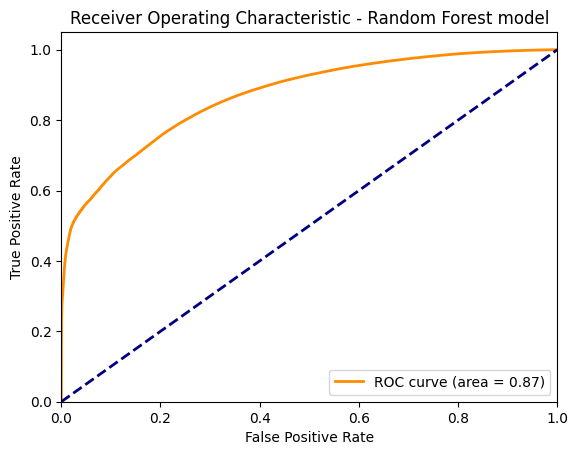

Accuracy: 0.86


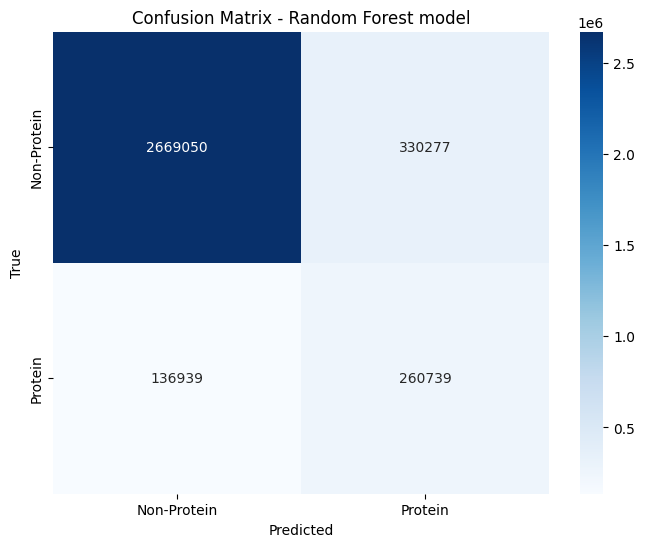

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92   2999327
           1       0.44      0.66      0.53    397678

    accuracy                           0.86   3397005
   macro avg       0.70      0.77      0.72   3397005
weighted avg       0.89      0.86      0.87   3397005



In [47]:
# Define file path
model_path = "/content/drive/MyDrive/DS5500/saved_models/Random_Forest.pkl"

# Load the saved Random Forest model
try:
    model = joblib.load(model_path)
    print(f"Loaded Random Forest model from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    raise


# Predictions
y_pred_eval = model.predict(X_eval)

# ROC Curve
fpr, tpr, _ = roc_curve(y_eval, model.predict_proba(X_eval)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest model')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

# Accuracy
acc = accuracy_score(y_eval, y_pred_eval)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_eval, y_pred_eval)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_eval, y_pred_eval))

In [48]:
# Metrics
pred_proba_eval = model.predict_proba(X_eval)[:, 1] if hasattr(model, "predict_proba") else None
accuracy = accuracy_score(y_eval, y_pred_eval)
weighted_map = (
  average_precision_score(y_eval, pred_proba_eval, average='weighted') if pred_proba_eval is not None else None
)

# Display results
print(f"Model: Random Forest model")
print(f"Accuracy: {accuracy:.2f}")
if weighted_map is not None:
  print(f"Weighted mAP: {weighted_map:.2f}")

Model: Random Forest model
Accuracy: 0.86
Weighted mAP: 0.65


##Decision Tree Baseline Model Evaluation

Loaded Decision Tree model from /content/drive/MyDrive/DS5500/Decision_Tree.pkl


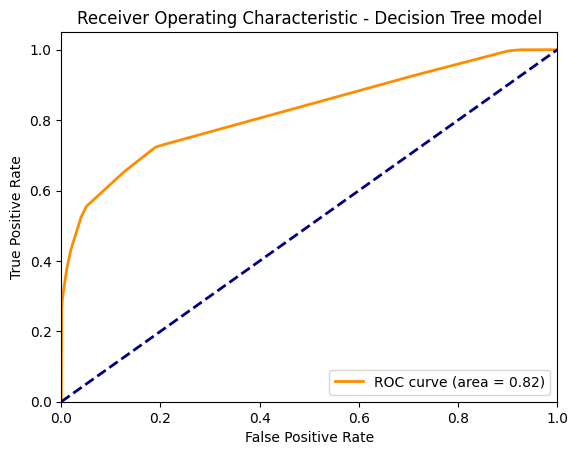

Accuracy: 0.80


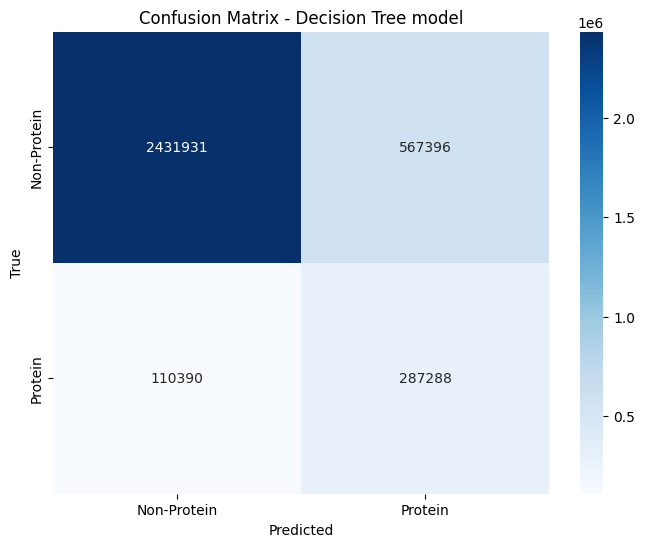

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88   2999327
           1       0.34      0.72      0.46    397678

    accuracy                           0.80   3397005
   macro avg       0.65      0.77      0.67   3397005
weighted avg       0.88      0.80      0.83   3397005



In [49]:
# Define file path
model_path = "/content/drive/MyDrive/DS5500/Decision_Tree.pkl"

# Load the saved Decision Tree model
try:
    model = joblib.load(model_path)
    print(f"Loaded Decision Tree model from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    raise


# Predictions
y_pred_eval = model.predict(X_eval)

# ROC Curve
fpr, tpr, _ = roc_curve(y_eval, model.predict_proba(X_eval)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Decision Tree model')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

# Accuracy
acc = accuracy_score(y_eval, y_pred_eval)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_eval, y_pred_eval)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_eval, y_pred_eval))

In [50]:
# Metrics
pred_proba_eval = model.predict_proba(X_eval)[:, 1] if hasattr(model, "predict_proba") else None
accuracy = accuracy_score(y_eval, y_pred_eval)
weighted_map = (
  average_precision_score(y_eval, pred_proba_eval, average='weighted') if pred_proba_eval is not None else None
)

# Display results
print(f"Model: Decision Tree model")
print(f"Accuracy: {accuracy:.2f}")
if weighted_map is not None:
  print(f"Weighted mAP: {weighted_map:.2f}")

Model: Decision Tree model
Accuracy: 0.80
Weighted mAP: 0.58


##Logistic Regression Baseline Model Evaluation

Loaded Decision Tree model from /content/drive/MyDrive/DS5500/saved_models/Logistic_Regression.pkl


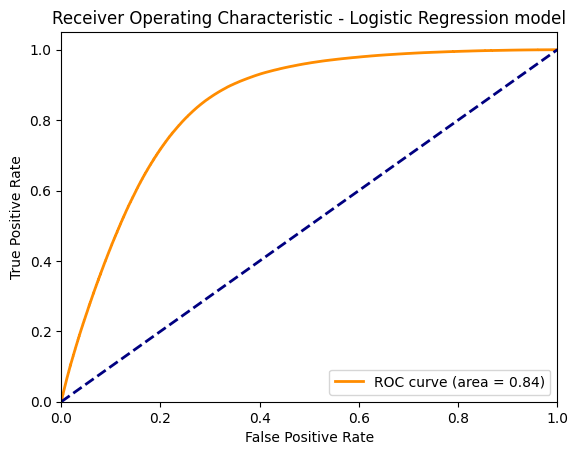

Accuracy: 0.76


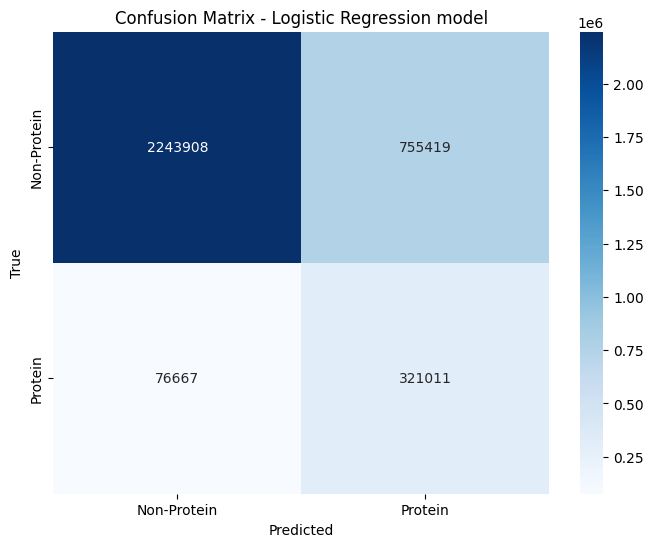

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.75      0.84   2999327
           1       0.30      0.81      0.44    397678

    accuracy                           0.76   3397005
   macro avg       0.63      0.78      0.64   3397005
weighted avg       0.89      0.76      0.80   3397005



In [51]:
# Define file path
model_path = "/content/drive/MyDrive/DS5500/saved_models/Logistic_Regression.pkl"

# Load the saved Logistic Regression model
try:
    model = joblib.load(model_path)
    print(f"Loaded Decision Tree model from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    raise


# Predictions
y_pred_eval = model.predict(X_eval)

# ROC Curve
fpr, tpr, _ = roc_curve(y_eval, model.predict_proba(X_eval)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression model')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

# Accuracy
acc = accuracy_score(y_eval, y_pred_eval)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_eval, y_pred_eval)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_eval, y_pred_eval))

In [52]:
# Metrics
pred_proba_eval = model.predict_proba(X_eval)[:, 1] if hasattr(model, "predict_proba") else None
accuracy = accuracy_score(y_eval, y_pred_eval)
weighted_map = (
  average_precision_score(y_eval, pred_proba_eval, average='weighted') if pred_proba_eval is not None else None
)

# Display results
print(f"Model: Logistic Regression model")
print(f"Accuracy: {accuracy:.2f}")
if weighted_map is not None:
  print(f"Weighted mAP: {weighted_map:.2f}")

Model: Logistic Regression model
Accuracy: 0.76
Weighted mAP: 0.35
